<a href="https://colab.research.google.com/github/james-t-little/bachelors_dissertation/blob/main/pb_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from tqdm import tqdm
from collections import Counter

import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.layers import Conv2D, MaxPool2D, Input, concatenate, Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.experimental.AUTOTUNE

seed = random.randint(1, 100)

In [ ]:
drive.mount('/content/drive')

IMG_SIZE = 256

if IMG_SIZE == 256:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/256'
elif IMG_SIZE == 512:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/512'

input_path = os.path.join(path,"image")
mask_path = os.path.join(path,"binary_mask")

Mounted at /content/drive


In [ ]:
image_input_path = sorted([ os.path.join(input_path, fname) for fname in os.listdir(input_path) if fname.endswith(".png") ])

image_mask_path = sorted([ os.path.join(mask_path, fname) for fname in os.listdir(mask_path) if fname.endswith(".png")])

path_df = pd.DataFrame({'image':image_input_path,'mask':image_mask_path})

In [ ]:
train, val = train_test_split(path_df,test_size=0.1, random_state=seed)

train, test = train_test_split(train,test_size=0.11, random_state=seed)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 16

imagegen = ImageDataGenerator(rescale=1/255)

maskgen = ImageDataGenerator(rescale=1/255)

def create_generator(generator, dataframe, colour_mode, batch_size, column):
    generator = generator.flow_from_dataframe(dataframe=dataframe,
                                    x_col=column,
                                    batch_size= batch_size,
                                    seed=seed,
                                    class_mode=None,
                                    color_mode=colour_mode) 
    return generator

train_img_gen = create_generator(imagegen, train, 'rgb', BATCH_SIZE, "image")

train_mask_gen = create_generator(maskgen, train, 'grayscale', BATCH_SIZE, "mask")

imagegen = ImageDataGenerator(rescale=1/255)
maskgen = ImageDataGenerator(rescale=1/255)

val_image_gen = create_generator(imagegen, val, 'rgb', BATCH_SIZE, "image")

val_mask_gen = create_generator(maskgen, val, 'grayscale', BATCH_SIZE, "mask")

test_image_gen = create_generator(imagegen, test, 'rgb', BATCH_SIZE, "image")

test_mask_gen = create_generator(maskgen, test, 'grayscale', BATCH_SIZE, "mask")

def zip_pair(image_gen,mask_gen):
    for img, mask in zip(image_gen,mask_gen):
        yield img, mask

train_gen = zip_pair(train_img_gen, train_mask_gen)
val_gen = zip_pair(val_image_gen,val_mask_gen)
test_gen = zip_pair(test_image_gen,val_mask_gen)

Found 3114 validated image filenames.
Found 3114 validated image filenames.
Found 389 validated image filenames.
Found 389 validated image filenames.
Found 385 validated image filenames.
Found 385 validated image filenames.


In [ ]:
def convolutional_layer_block(previous_layer, filter_size, kernel):
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(previous_layer)
        x = Dropout(0.01)(x)
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

def u_net(img_shape, n_classes, filter_start):
    inputs = Input(shape=img_shape)
    previous_layer = inputs

    filter_list = [filter_start, filter_start * 2, filter_start * 4, filter_start * 8]

    concatenate_link = []
    for filter_size in filter_list:
        x = convolutional_layer_block(previous_layer, filter_size, (3,3))
        concatenate_link.append(x)
        x = MaxPooling2D((2, 2))(x)
        previous_layer = x

    concatenate_link = list(reversed(concatenate_link))
    x = convolutional_layer_block(previous_layer, 256, (3,3))
    previous_layer = x

    for count,filter_size in enumerate(reversed(filter_list)):
        x = Conv2DTranspose(filter_size, (2, 2), strides=(2, 2), padding='same')(previous_layer)
        x = concatenate([x, concatenate_link[count]], axis = 3)
        convolutional_layer_block(x, filter_size, (3,3))
        previous_layer = x

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, kernel_size=(1, 1), activation=activation)(previous_layer)

    return Model(inputs=inputs, outputs=outputs)

model = u_net((IMG_SIZE, IMG_SIZE, 3), n_classes = 1, filter_start = 32)

In [ ]:
model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])

callbacks = [tf.keras.callbacks.ModelCheckpoint(("/content/drive/MyDrive/"+'boundary_model_e100_bs4.h5'), verbose = 1, save_best_only=True, save_weights_only=True)]

train_step = train_img_gen.n / BATCH_SIZE
val_step = val_mask_gen.n / BATCH_SIZE

trained_model = model.fit(train_gen, steps_per_epoch = train_step, epochs= EPOCHS, validation_data = val_gen, validation_steps = val_step, callbacks = callbacks)


Epoch 1/10
195/194 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8589
Epoch 1: val_loss improved from inf to 0.35550, saving model to /content/drive/MyDrive/boundary_model_e100_bs4.h5
194/194 [==============================] - 571s 3s/step - loss: 0.3928 - accuracy: 0.8589 - val_loss: 0.3555 - val_accuracy: 0.8596
Epoch 2/10
195/194 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.8631
Epoch 2: val_loss improved from 0.35550 to 0.32188, saving model to /content/drive/MyDrive/boundary_model_e100_bs4.h5
194/194 [==============================] - 32s 167ms/step - loss: 0.3363 - accuracy: 0.8631 - val_loss: 0.3219 - val_accuracy: 0.8659
Epoch 3/10
195/194 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.8686
Epoch 3: val_loss improved from 0.32188 to 0.30530, saving model to /content/drive/MyDrive/boundary_model_e100_bs4.h5
194/194 [==============================] - 32s 165ms/step - loss: 0.3111 - accuracy: 0.8686 - va

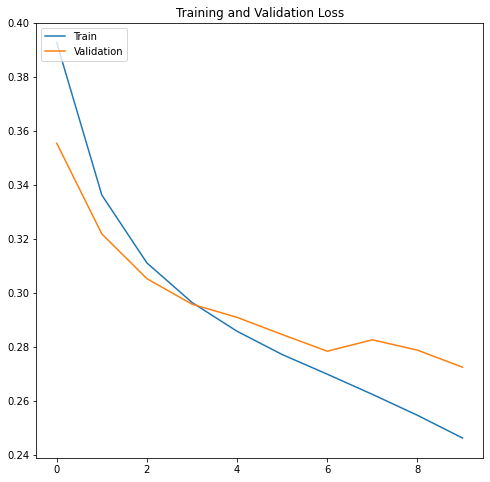

In [ ]:

loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']


def plot_training_data(graph_name, train_metric, val_metric):
    plt.figure(figsize = (8,8))
    plt.plot(train_metric, label = "Train")
    plt.plot(val_metric, label = "Validation")
    plt.title(graph_name)
    plt.legend(loc="upper left")
    plt.show()
    
plot_training_data("Training and Validation Loss", loss, val_loss)

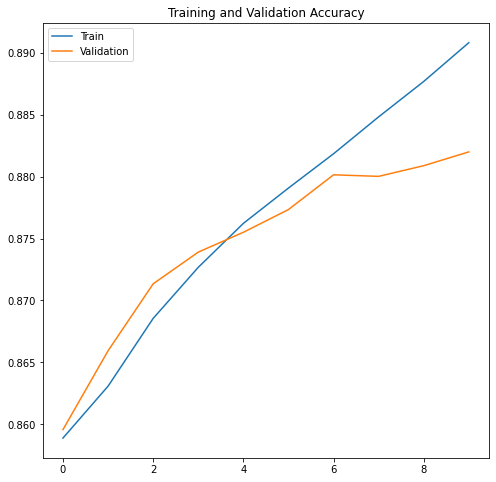

In [ ]:
plot_training_data("Training and Validation Accuracy", accuracy, val_accuracy)

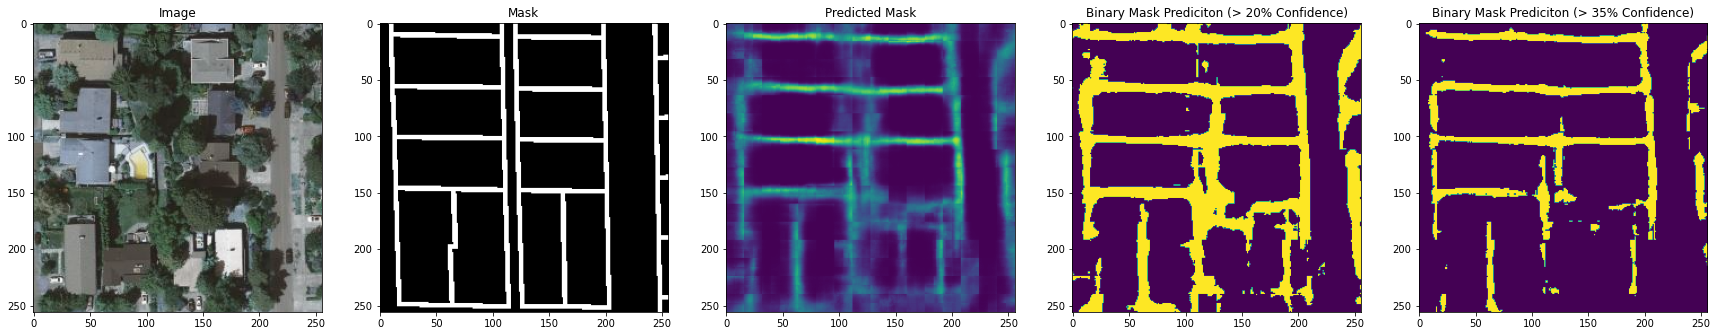

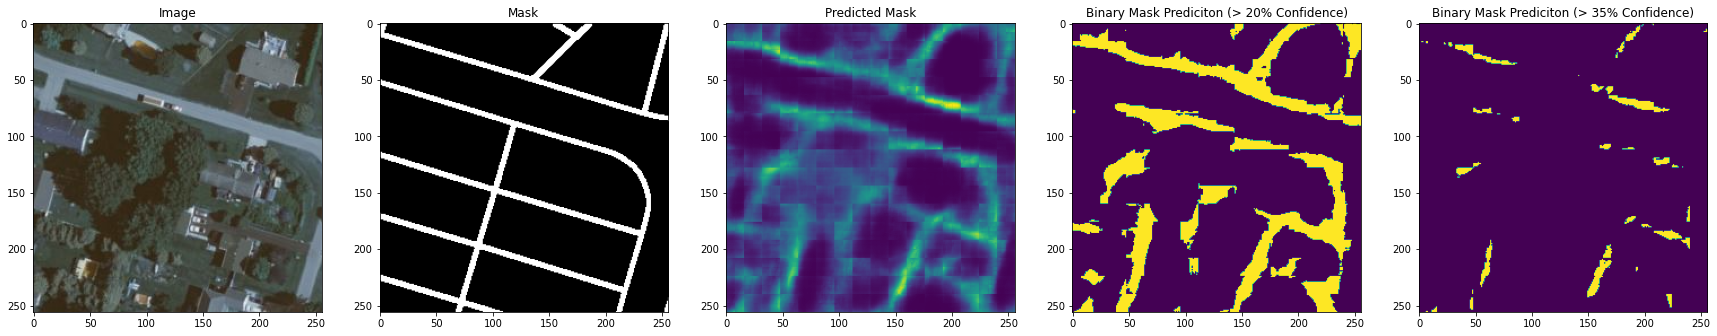

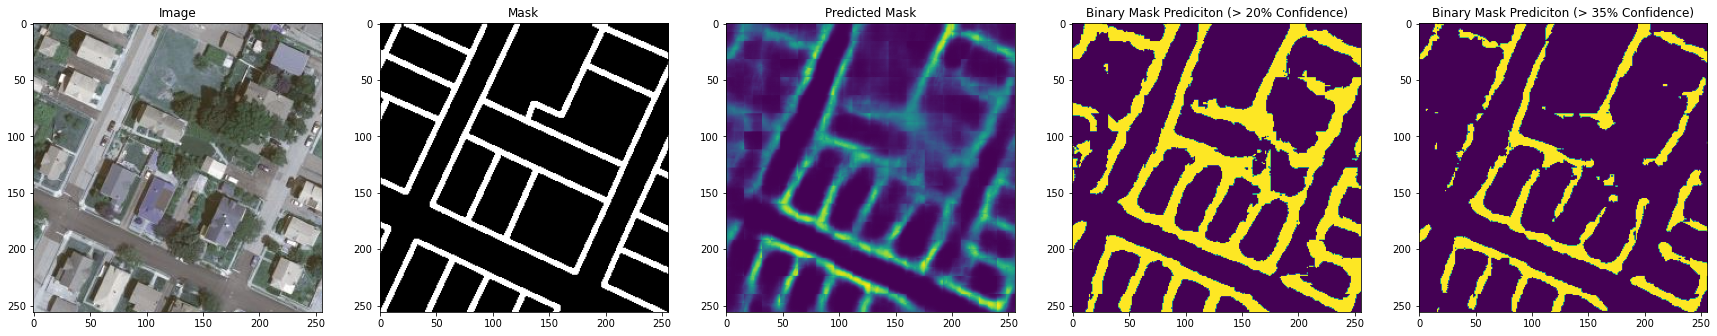

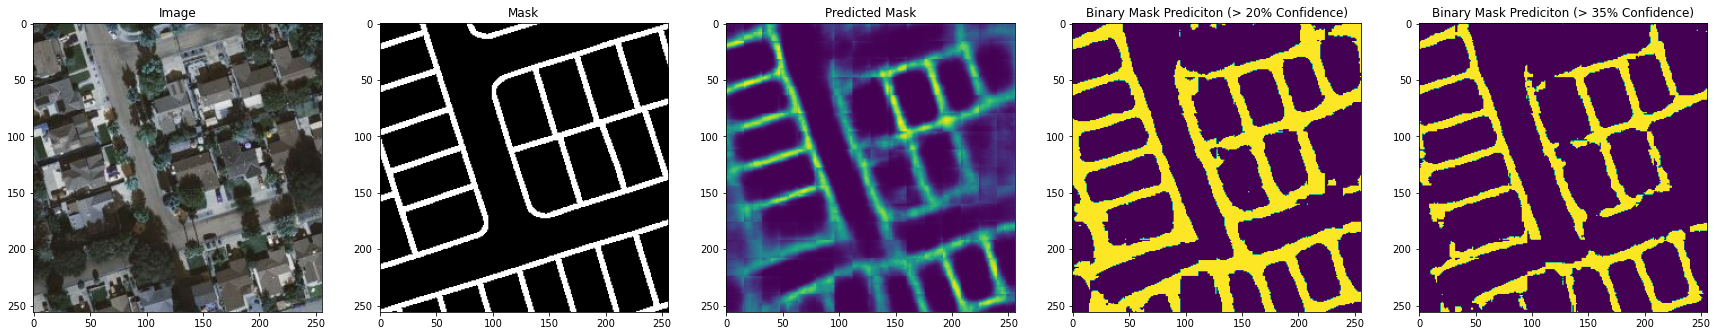

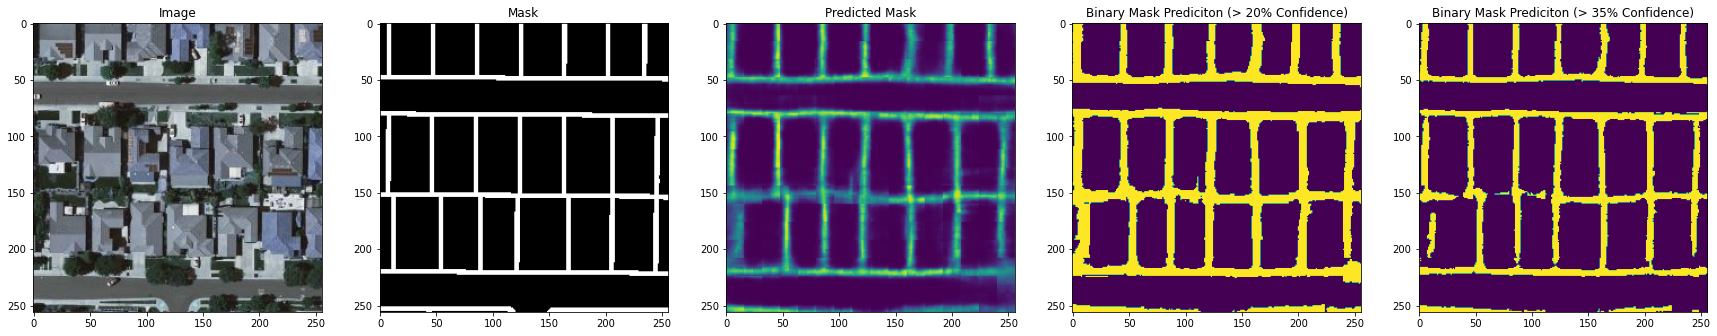

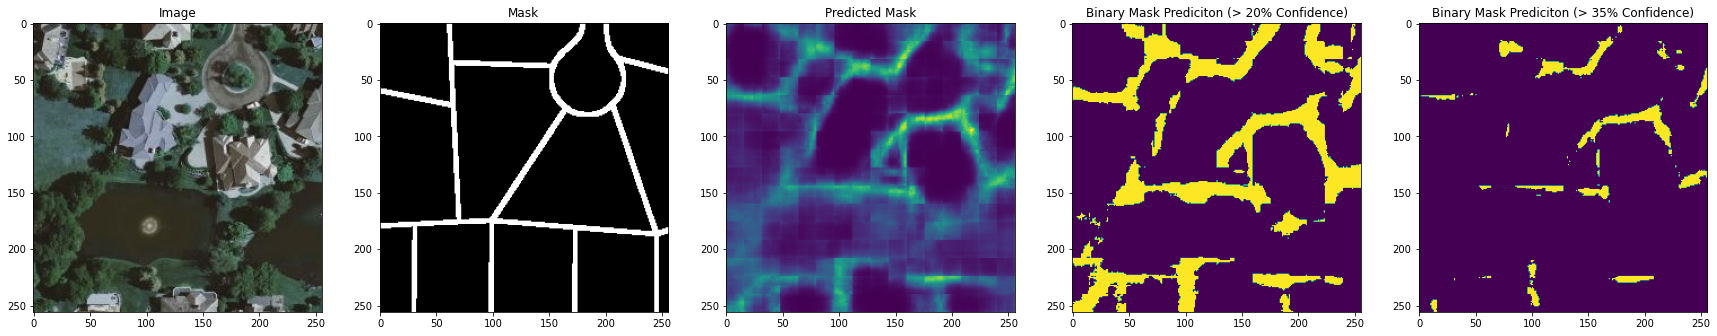

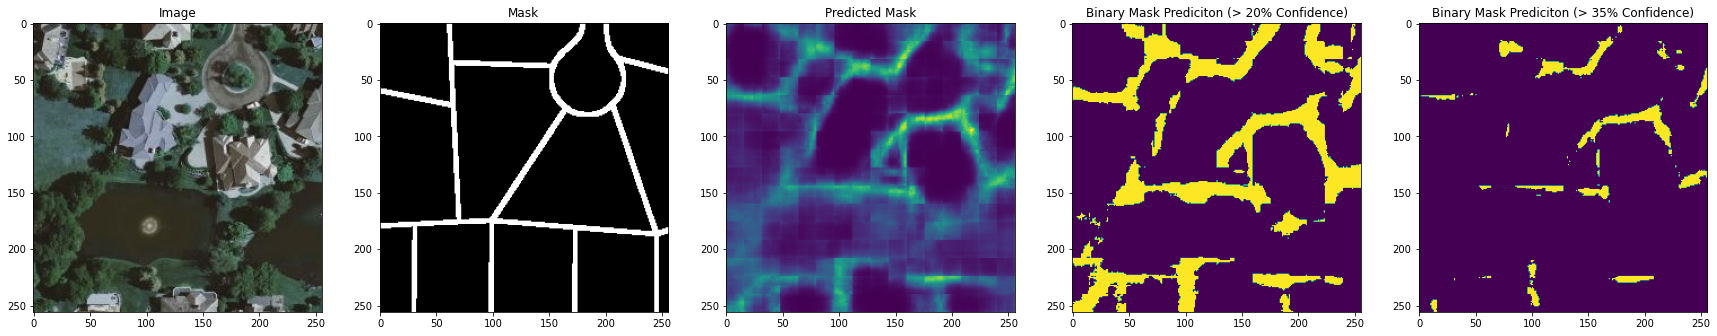

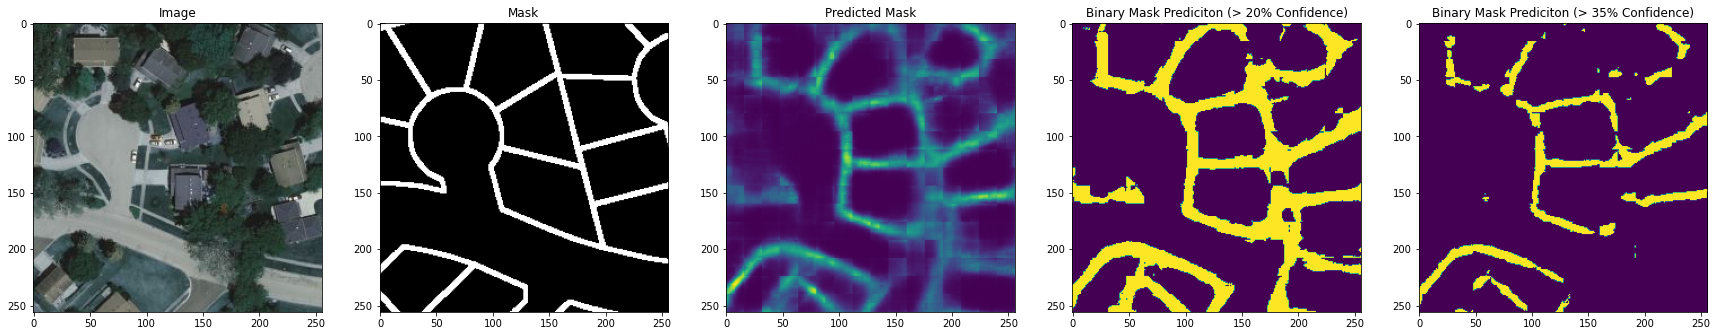

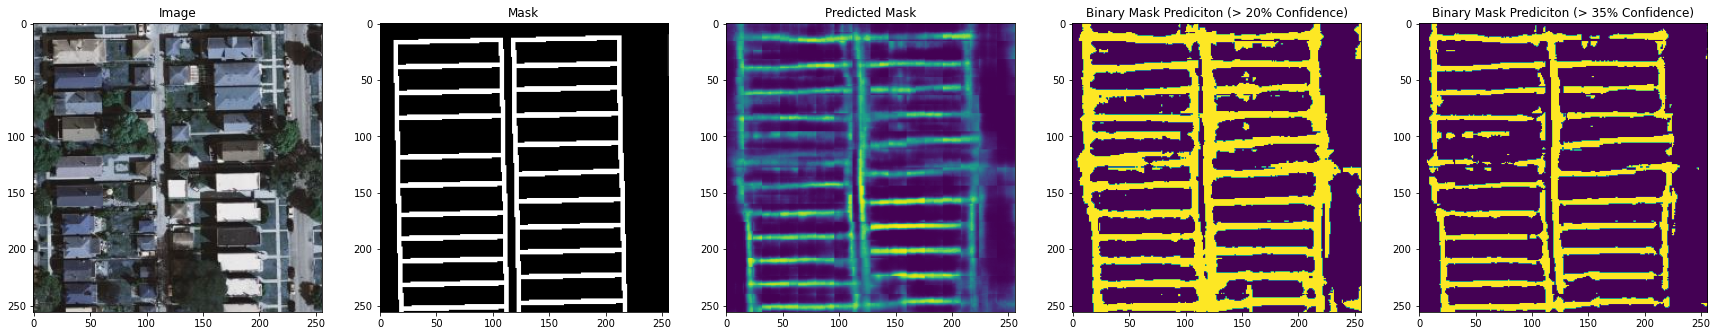

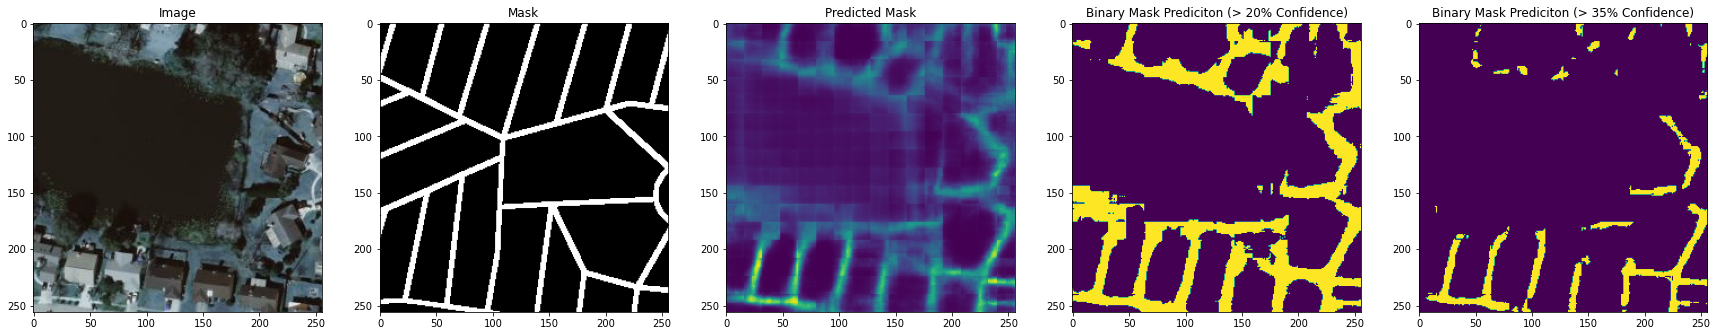

In [ ]:
def predict_img(img_path,mask_path):
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
    image = image/255
    image = image[np.newaxis,:,:,:]
    pred_mask = model.predict(image) 
    return image, mask, pred_mask

def show_prediction(img,mask,pred_mask):
    plt.figure(figsize=(30,30))
    plt.subplot(1,5,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,5,2)
    plt.imshow(np.squeeze(mask))
    plt.title('Mask')
    plt.subplot(1,5,3)
    plt.imshow(np.squeeze(pred_mask))
    plt.title('Predicted Mask')
    plt.subplot(1,5,4)
    plt.imshow(np.squeeze(pred_mask) > 0.2)
    plt.title('Binary Mask Prediciton (> 20% Confidence)')
    plt.subplot(1,5,5)
    plt.imshow(np.squeeze(pred_mask) > 0.35)
    plt.title('Binary Mask Prediciton (> 35% Confidence)')
    plt.show()


for num in range(30):
    index = random.randint(1, len(test))
    img_path = test['image'][index]
    mask_path = test['mask'][index]
    img,mask,pred_mask =  predict_img(img_path,mask_path)
    show_prediction(img,mask,pred_mask)